Make true-colour cutouts from HSC data

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

In [3]:
dataPath = "/Volumes/RHLData/hsc-v13_0"

butler = dafPersist.Butler(dataPath)
skymap = butler.get("deepCoadd_skyMap")

Select the object of which we want a Pretty Picture.

For coadds the WCS is the same in all bands, but the code handles the general case

In [4]:
ra, dec, name = 215.9747, -0.4344, "Lens"

raDec = afwCoord.Coord(ra*afwGeom.degrees, dec*afwGeom.degrees)

filters = "grizy"  # filters to process -- we choose our bands when we set B, R, G = ...

cutoutSize = 500   # pixels

Start by finding the tract and patch

In [5]:
for i, tp in enumerate(skymap.findTractPatchList([raDec])):
    tractInfo, patchInfo = tp
    tract = tractInfo.getId()
    patch = "%d,%d" % patchInfo[0].getIndex()
    print i, tract, patch

0 9372 6,6


Then we can read the desired pixels

In [6]:
images = {}
cutoutSize = afwGeom.ExtentI(300, 200)

for f in filters:
    filterName = "HSC-%s" % f.upper()
    md = butler.get("deepCoadd_calexp_md", immediate=True,
                    tract=tract, patch=patch, filter=filterName)
    wcs = afwImage.makeWcs(md)
    xy = afwGeom.PointI(wcs.skyToPixel(raDec))

    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

    images[f] = butler.get("deepCoadd_calexp_sub", bbox=bbox, immediate=True,
                            tract=tract, patch=patch, filter=filterName).getMaskedImage()

Generate a RGB images, and optionally write to disk

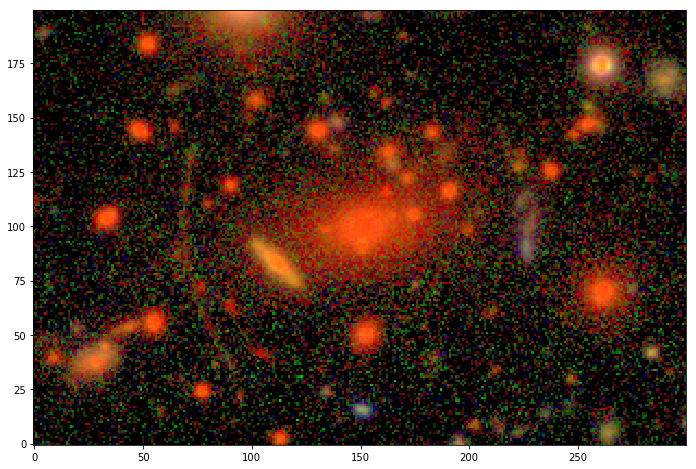

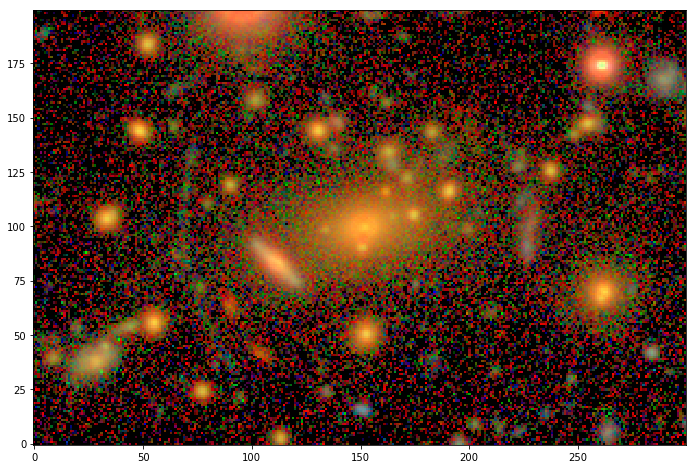

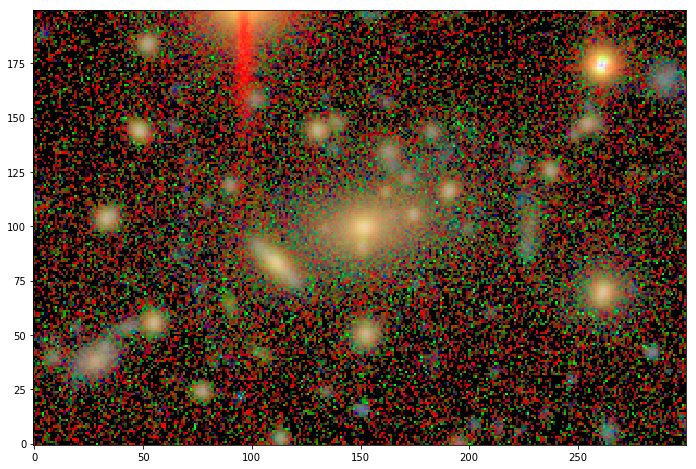

In [7]:
rgbFileFmt = "%s-%%s.png" % name if False else None
if not False:
    min = dict(gri=0.01, riz=0.01, izy=0.01)
    max = dict(gri=0.20, riz=0.20, izy=0.25)
else:
    min = dict(gri=0.01, riz=0.01, izy=0.05)
    max = dict(gri=0.20, riz=0.40, izy=0.50)

Q = 10

for bands in ["gri", "riz", "izy"]:
    B, G, R = bands
    rgb = afwRgb.makeRGB(images[R], images[G], images[B],
                         min[bands], max[bands] - min[bands], Q,
                         #saturatedBorderWidth=1, saturatedPixelValue=10
                         )
    
    afwRgb.displayRGB(rgb)
    
    if rgbFileFmt:
        afwRgb.writeRGB(rgbFileFmt % bands, rgb)